# <CENTER>**`III.` `FEATURE ENGINEERING` - Gurugram Real Estate Project**<CENTER>
---

## **Gurgaon Real Estate Project :**

In the previous step, we have completed the **first round of Exploratory Data Analysis (EDA)** on our cleaned dataset. The initial EDA helped us understand the structure of our data, distribution of features, relationships between variables, and potential gaps.

One key insight from the analysis was the **variation in 'amenities' across sectors**. Certain sectors consistently offer more facilities (parks, gyms, schools, hospitals, etc.) than others, and this difference could influence property prices and buyer preferences.

To capture these differences and enhance both our **machine learning models** and the **analytic module of the web application**, we will enrich our dataset with **new features** such as:

* **`Amenity_Score`** – A sector-level numerical score representing the quality and quantity of available amenities.
* **This engineered feature is expected to:**
    1. **Encode sector livability** in a measurable form
    2. **Improve model performance** by providing a richer representation of location quality
    3. Help **distinguish between properties in high-amenity vs. low-amenity sectors**

* **Geo-spatial features** – Latitude/longitude coordinates for sectors and key amenities, enabling spatial analysis and interactive mapping in the web app

### **Objectives of this Notebook**

1. Load the cleaned dataset from the previous stage
2. **Prepare** the **sector-level amenity dataset** and **geo-spatial data**
3. Design scoring logic for `Amenity_Score`
4. Integrate geo-spatial coordinates for sectors and amenities too *(if possible)*
5. Merge all engineered features back into the main dataset
6. Validate features with quick EDA (distribution, correlation with price, mapping previews)
7. Save the enhanced dataset for:
   * **Round 2 EDA** before modeling
   * **Web App Analytic Module** for richer location-based insights

By the end of this notebook, we will have an **enriched, location-aware dataset** ready for deeper analysis, better model training, and more informative web app visualizations.

---
---

In [3]:
## Importing all the necessary tools:
import pandas as pd
import numpy as np
import osmnx as ox
import folium
import random
from shapely.geometry import Point

pd.options.display.max_columns = None

In [4]:
df = pd.read_csv('Housing_Listings_all_records_(numbers)_FINAL_Cleaned.csv', index_col = 'Unnamed: 0')

df.sample(3)

,Flat,Sector,Address,Seller_Builder,EMI,EMI_in_rupees,Built_Up_Area,Built_up_area_in_sqft,Avg_Price,Avg_price_rupee_per_sqft,Age_of_property,Age_of_property_in_years,Possession_status,Floor,Floor_number,Building_height,Facing,Furnishing,Society,Brokerage,Brokerage_in_rupees,Price,Price_in_rupees,Bedrooms,Bathrooms,Parking,Covered_parking,Open_parking,Balcony,Advertised,Amenities,Nearby_landmarks,Prop_description,Link
3634,3 BHK Flat,Sector 83,"Emaar Palm Gardens, Sector 83, Gurgaon",Emaar,EMI starts at ₹1.49 Lacs,149000,1900 sq.ft,1900,₹15.79 K/sq.ft,15790.0,6 Year Old,6,Ready to move,7 of 15,7,15,-,Semi Furnished,Emaar Palm Gardens,3 Lacs,300000,3.0 Cr,30000000,3,3,1 Covered and 1 Open Parking,1,1,4,26 days ago,"['Gas Pipeline', 'Cupboard', '4Fan', '4Light',...","[['School', 'Euro International School, Sector...","A 3 BHK Flat for sale in Sector 83, Gurgaon. T...",https://housing.com/in/buy/resale/page/1773605...
5571,3 BHK Flat,Sector 108,"Sobha City, Sector 108, Gurgaon",Sobha Limited,EMI starts at ₹2.23 Lacs,223000,2250 sq.ft,2250,₹20 K/sq.ft,20000.0,1 Years Old,1,Ready to move,8 of 24,8,24,East facing,Semi Furnished,Sobha City,4.5 Lacs,450000,4.5 Cr,45000000,3,4,1 Covered and 1 Open Parking,1,1,2,16 days ago,"['Swimming Pool', 'Gym', 'Lift', 'Power Backup...","[['School', 'Euro International School, Sector...","Property for sale in Nanak Heri Village, Gurga...",https://housing.com/in/buy/resale/page/1781921...
1981,2 BHK Flat,Sector 33,"Unitech The Residences, Sector 33, Gurgaon",Unitech Limited,EMI starts at ₹84.4 K,84400,1095 sq.ft,1095,₹15.53 K/sq.ft,15530.0,10 Year Old,10,Ready to move,9 of 14,9,14,North-East facing,Semi Furnished,Unitech The Residences,1.7 Lacs,170000,1.7 Cr,17000000,2,2,1 Covered and 1 Open Parking,1,1,2,More than a month ago,"['AC', 'Cupboard', 'Geyser']","[['School', 'Manav Rachna International School...",Check out this 2 BHK Flat for sale in Sector 3...,https://housing.com/in/buy/resale/page/1744443...


## What new Features we must add:
- Add feature for Locality of Gurgaon where the given Sector falls.
- Add feature for key Amenities in that sector.
- Create feature to score Locality by present Amenity.
- Create feature to score Sectors by present Amenity.
- Create feature to score Society by present Amenity.
- Find a methodology to categorise properties as Luxury or Non-luxury.

In [6]:
## Loading the cleaned dataset:
df = pd.read_csv('Housing_Listings_all_records_(numbers)_FINAL_Cleaned.csv', index_col = 'Unnamed: 0')
df.head(3)

,Flat,Sector,Address,Seller_Builder,EMI,EMI_in_rupees,Built_Up_Area,Built_up_area_in_sqft,Avg_Price,Avg_price_rupee_per_sqft,Age_of_property,Age_of_property_in_years,Possession_status,Floor,Floor_number,Building_height,Facing,Furnishing,Society,Brokerage,Brokerage_in_rupees,Price,Price_in_rupees,Bedrooms,Bathrooms,Parking,Covered_parking,Open_parking,Balcony,Advertised,Amenities,Nearby_landmarks,Prop_description,Link
0,2 BHK Flat,Sector 86,"Pyramid Elite, Sector 86, Gurgaon",Pyramid Infratech Private Limited,EMI starts at ₹36.01 K,36010,593 sq.ft,593,₹11.47 K/sq.ft,11470.0,1 Years Old,1,Ready to move,12 of 14,12,14,East facing,Semi Furnished,Pyramid Elite,"68,000",68000,68.0 L,6800000,2,2,1 Open Parking,0,1,1,More than a month ago,"['Lift', 'Power Backup', 'Garden', 'Sports', '...","[['School', ""St. Xavier's High School""], ['Hos...",Looking for a 2 BHK Flat for sale in Gurgaon? ...,https://housing.com/in/buy/resale/page/1761033...
1,2 BHK Flat,Sector 86,"Pyramid Elite, Sector 86, Gurgaon",Pyramid Infratech Private Limited,EMI starts at ₹33.36 K,33360,690 sq.ft,690,₹9.13 K/sq.ft,9130.0,1 Years Old,1,Ready to move,4 of 15,4,15,-,Unfurnished,Pyramid Elite,"63,000",63000,63.0 L,6300000,2,2,No Parking,0,0,1,17 days ago,NaN,"[['School', ""St. Xavier's High School""], ['Hos...",Best 2 BHK Flat for modern-day lifestyle is no...,https://housing.com/in/buy/resale/page/1681859...
2,2 BHK Flat,Sector 108,"Experion The Heartsong, Sector 108, Gurgaon",Experion Developers,EMI starts at ₹74.47 K,74470,1000 sq.ft,1000,₹15 K/sq.ft,15000.0,2 Year Old,2,Ready to move,9 of 26,9,26,North-East facing,Semi Furnished,Experion The Heartsong,1.5 Lacs,150000,1.5 Cr,15000000,2,2,1 Covered and 1 Open Parking,1,1,3,More than a month ago,"['Amphitheater', 'Cricket Pitch', 'Gazebo', 'S...","[['School', 'The Shikshiyan School'], ['Hospit...","2 BHK Flat for sale in Sector 108, Gurgaon - c...",https://housing.com/in/buy/resale/page/1767484...


---
## **`I. Gathering & Preparing Geo Spatial Data of Sectors : `**

- We'll primarily use open source platform 'OpenStreetMap'.
- We'll try to scrap boundary data for Sectors to plot their boundary on Map.  

In [253]:
## Scrapping Gurgaon Sector's Geo Spatial Data from 'OpenStreetMap' for Map work: 

# Step 1: Define query to access data of all 'Sectors' in Gurugram
place_name = "Gurugram, Haryana, India"
tags = {"place": True , 'landuse':True, "amenity": True, "building": True, "highway": True, "leisure": True, 
        "natural": True, "shop": True, "tourism": True, "office": True, "public_transport": True, "railway": True, 
        "boundary": True}

# Step 2: Download all Boundary Tagged data of Gurugram - includes Sector-wise data (not for all)
gdf = ox.geometries_from_place(place_name, tags={"boundary": True})

# Renaming certain sectors as necessary:
gdf['name'] = gdf['name'].replace(['HUDA Sector 27', 'HUDA Sector 43'], ['Sector 27', 'Sector 43'])

# Indexing necessary data points:
unique_names_gdf = pd.Series(gdf['name'].unique())
                             
all_sectors = unique_names_gdf[unique_names_gdf.str.contains('Sector').fillna(False)].values

sectors = gdf[gdf['name'].isin(all_sectors)][['name', 'geometry', 'boundary']].reset_index(drop = True)

## Keeping only geometry of type 'Polygons' and 'MultiPolygons':
sectors = sectors[(sectors['geometry'].geom_type != 'LineString')]

## Removing all duplicated records:
sectors = sectors[~ sectors['name'].duplicated()].reset_index(drop = True)

sectors.to_csv('sectors_geo_boundary_data.csv')

sectors.head()

C:\Users\Vishal\Anaconda3\Lib\site-packages\osmnx\geometries.py:228: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  polygon = gdf_place["geometry"].unary_union
C:\Users\Vishal\AppData\Local\Temp\ipykernel_18300\1834474471.py:18: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  all_sectors = unique_names_gdf[unique_names_gdf.str.contains('Sector').fillna(False)].values


,name,geometry,boundary
0,Sector 26,"POLYGON ((77.09375 28.47891, 77.09432 28.47974...",administrative
1,Sector 14,"POLYGON ((77.03379 28.46385, 77.03786 28.46836...",place
2,Sector 78,"POLYGON ((76.9614 28.37906, 76.97026 28.38359,...",administrative
3,Sector 80,"POLYGON ((76.9568 28.37653, 76.9614 28.37906, ...",administrative
4,Sector 45,"POLYGON ((77.0582 28.44387, 77.06096 28.44677,...",administrative


In [255]:
## Sectors for which we don't have Geo Spatial Data:
print("Sectors for which Geo Spatial data not found : \n" , 
      df['Sector'][~ df['Sector'].isin(sectors['name'].unique())].unique()[1:])

print("\nThese are total : ", len(df['Sector'][~ df['Sector'
                                ].isin(sectors['name'].unique())].unique()[1:]))

Sectors for which Geo Spatial data not found : 
 ['Sector 95' 'Sector 76' 'Sector 63' 'Sector 79' 'Sector 67' 'Sector 70'
 'Sector 35' 'Sector 89A' 'Sector 68' 'Sector 99A' 'Sector 99'
 'Sector 95A' 'Sector 77' 'Sector 10A' 'Sector 69' 'Sector 36A'
 'Sector 60' 'Sector 88B' 'Sector 48' 'Sector 63A' 'Sector 22A'
 'Sector 59' 'Sector 17A']

These are total :  23


#### `NOTE :`
- We got Geo Spatial Boundary data for 88 Sectors. In our dataset, we have 111 Sectors in total.
- We still need data for 23 more Sectors (i.e., 'Sector 67', 'Sector 79', 'Sector 77', 'Sector 59', 'Sector 70', 'Sector 99', 'Sector 99A', 'Sector 76', 'Sector 95', 'Sector 60'   'Sector 89A', 'Sector 35', 'Sector 95A', 'Sector 48', 'Sector 63    'Sector 36A', 'Sector 22A', 'Sector 88B', 'Sector 10A', 'Sector 63 '   'Sector 17A'). First 10 of these Sectors have 60+ property listings.
- We can do one thing, for Map Work, plot polygons for Sectors where boundary data is available and for rest directly plot the Centroid from, osmnx.

---
---
## **`II. Gathering Sector-wise Amenity Data & developing Amenity Score:`**

- For Sector-wise amenity data, we'll scrap overall amenity data available for Gurugram from 'OpenStreetMap', and then Map their locations to Sectors using Sector's Centroid Location.
- Based on resultant mapping, we'll then develop a criterion to award Amenity Score to sector using Sector-wise Amenity data.

In [28]:
## First we need Geo Centroid (point location) of each Sector:
sectors_location = pd.DataFrame()

sectors_list = sorted(df[df['Sector'].str.contains('Sector')]['Sector'].unique())

## Accurate location not available for below list of sectors...
for j in ['Sector 17A', 'Sector 22A', 'Sector 63A', 'Sector 79', 'Sector 89A', 'Sector 95A']: 
    sectors_list.remove(j)

for sector in sectors_list: 
    location_name = sector + ", Gurugram, Haryana, India"
    point = ox.geocode(location_name)  # returns (lat, lon) as (y, x)
    sectors_location = pd.concat([sectors_location , 
                                  pd.DataFrame({"Sector": sector, "Location_(lat_long)": [point]})], 
                                 ignore_index=True)


## Sector 95A, Sector 89A & Sector 79 togther constitute 34 + 54 + 134 = 222 data points
## Also adding Sector 17A, Sector 22A, & Sector 63A totalling 16 data points
## lets add there Centroids to the dataframe:
manually_added_info = [("Sector 95A", (28.426163887448066, 76.92446670817928)), 
                       ("Sector 89A", (28.432278916542593, 76.94137572662338)), 
                       ("Sector 79", (28.36397715506277, 76.9805550962224)),
                       ("Sector 17A", (28.4782746802606, 77.05779005474827)),
                       ("Sector 22A", (28.505716964038275, 77.07207837211523)),
                       ("Sector 63A", (28.39186544402343, 77.08978257840688))]

for sector, location in manually_added_info:
    sectors_location = pd.concat([sectors_location , 
                                  pd.DataFrame({"Sector": sector, "Location_(lat_long)": [location]})], 
                                 ignore_index=True)

print(sectors_location.shape)
sectors_location.head()

(111, 2)


,Sector,Location_(lat_long)
0,Sector 1,"(28.5187813, 77.0418623)"
1,Sector 102,"(28.4754872, 76.9711747)"
2,Sector 102A,"(28.4830826, 76.9779064)"
3,Sector 103,"(28.493087, 76.9866453)"
4,Sector 104,"(28.4795324, 76.9937197)"


### NOTE:
- We **got Centroid Locations of 105 Sectors** out of required **111 Sectors**.
- For **'Sector 17A', 'Sector 22A', 'Sector 63A', 'Sector 79', 'Sector 89A', 'Sector 95A'**, we could'nt find centroid data from OpenStreetMap. So we manually add their centroid data from Google Maps.

<hr>

<br><br>

## **Dividing Gurugram in Broad Localities or Neighbourhoods :**
-  **Marking Sectors with "Borader Locality" it falls in:**
- There are **6 Major Localities in Gurgram** - i.e., **"New Gurugram", "Golf Course Road & Extension", "Dwarka Expressway Belt", "MG Road & Central Gurugram", "Southern Peripheral Road (SPR) Belt" and "Old Gurgaon"**.
- We can mark the Sectors in our data with these Localities.

In [17]:
## List of all unique Sectors in data:
sectors = df[df['Sector'] != '-']['Sector'].unique()

## Helper to extract Sector number and Alphabetical Suffix
import re

def parse_sector(s):
    m = re.search(r"Sector\s+(\d+)([A-Z]?)", s)
    if not m:
        return None, None
    num = int(m.group(1))
    suf = m.group(2) if m.group(2) else ''
    return num, suf

# Locality mapping rules based on public references
new_gurgaon_nums = list(range(76,96))
new_gurgaon_suffix = {('95','A'), ('82','A')}  # include 95A, 82A

# Dwarka Expressway belt per sector clusters
dwarka_nums = set([99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114])
dwarka_suffix = {('99','A'), ('102','A'), ('110','A')}

# Golf Course Road & Extension
gcr_ext_nums = set([42,53,54,55,56,58,59,60,61,62,63,65,66,67,50])
gcr_ext_suffix = {('63','A')}

# Southern Peripheral Road (SPR) Belt
spr_nums = set([68,69,70,71,72,73,74,75])
spr_suffix = {('70','A'), ('72','A')}

locality_list = ["New Gurugram", "Golf Course Road & Extension", "Dwarka Expressway Belt", 
                 "MG Road & Central Gurugram", "Southern Peripheral Road (SPR) Belt", "Old Gurgaon"]

localities = []
for s in sectors:
    num, suf = parse_sector(s)
    key = (str(num), suf)
    loc = None
    # Order: DXP override then New Gurgaon (overlaps 102-113), then GCR Extn, then SPR, else Old Gurgaon
    if (num in dwarka_nums) or (key in dwarka_suffix):
        loc = "Dwarka Expressway Belt"
    elif (num in new_gurgaon_nums) or (key in new_gurgaon_suffix):
        loc = "New Gurugram"
    elif (num in gcr_ext_nums) or (key in gcr_ext_suffix):
        loc = "Golf Course Road & Extension"
    elif (num in spr_nums) or (key in spr_suffix):
        loc = "Southern Peripheral Road (SPR) Belt"
    elif num in [27,28,29,30,31,39,40,41,43,45,46,47,48,49,51,52,57]:
        loc = "MG Road & Central Gurugram"
    else:
        loc = "Old Gurgaon"
    localities.append(loc)

# Build DataFrame with empty geo_polygon to be filled later when authoritative polygons are fetched
import numpy as np

sec_local = pd.DataFrame({'Sector': sectors, 'Locality': localities,})
sec_local.head()

,Sector,Locality
0,Sector 86,New Gurugram
1,Sector 108,Dwarka Expressway Belt
2,Sector 102,Dwarka Expressway Belt
3,Sector 37D,Old Gurgaon
4,Sector 70A,Southern Peripheral Road (SPR) Belt


In [23]:
## Now merging the above DF with Geo Spatial data DF:
sectors_location = pd.merge(sectors_location, sec_local, on='Sector')
sectors_location.head(5)

,Sector,Location_(lat_long),Locality
0,Sector 1,"(28.5187813, 77.0418623)",Old Gurgaon
1,Sector 102,"(28.4754872, 76.9711747)",Dwarka Expressway Belt
2,Sector 102A,"(28.4830826, 76.9779064)",Dwarka Expressway Belt
3,Sector 103,"(28.493087, 76.9866453)",Dwarka Expressway Belt
4,Sector 104,"(28.4795324, 76.9937197)",Dwarka Expressway Belt


In [25]:
## Now, saving it into CSV file for future Analytic use:
sectors_location.to_csv('sector_geo_centroid_data.csv')

----

<br>

### **Scrapping Gurugram Amenity Data from OpenStreetMap:**

In [30]:
## Defining query to access data of all 'Amenities' in Gurugram
place_name = "Gurugram, Haryana, India"
tags = {"place": True , 'landuse':True, "amenity": True, "building": True, "highway": True, 
        "leisure": True, "natural": True, "shop": True, "tourism": True, "office": True, 
        "public_transport": True, "railway": True, "boundary": True}

## Downloading data for all Amenities around Gurugram
gdf = ox.geometries_from_place(place_name, tags={"amenity": True})  

## Keeping 15 most necessary Amenities for comfortable living
top_amenities = gdf['amenity'].value_counts().head(15).index

amenities = gdf[gdf['amenity'].isin(top_amenities)][['amenity', 'name', 
                                                     'geometry']].reset_index(drop=True)

amenities.sample(5)

,amenity,name,geometry
689,clinic,NaN,POINT (77.0688 28.45418)
887,fast_food,D S Hunger Hut,POINT (77.07964 28.44912)
798,bench,NaN,POINT (77.04129 28.45428)
904,hospital,Dr. Himani Yadav | Cosmetic Surgeon In Gurgaon...,POINT (77.07771 28.42997)
556,clinic,Kidney Clinic,POINT (77.02642 28.46808)


---

### **Labeling Amenities of Gurugram with List of Closest Sectors (within 2.5KM range) :**

In [32]:
## Labeling all the amenities with Sectors:
from geopy.distance import geodesic

## Creating DF where all Amenities are labeled with Sector they are closest to:
amenity_sector_data = pd.DataFrame()

for amenity, name, point in amenities.values:
    ## Get centroid for location with polygonal geometry...
    if point.geom_type == 'Polygon':
        point = point.centroid
    elif point.geom_type == 'MultiPolygon':
        point = point.representative_point()
    else:
        pass  # Skip non-polygonal geometries

    ## Now calculating distance of Amenity with each Sectoral Centroid and choosing the closest one:
    closest_sectors = []
    
    for sector, location in sectors_location.values:
        ## Define two locations (latitude, longitude)
        point1 = (point.y, point.x)
        point2 = (location[0], location[1])
        
        ## Calculate geodesic distance
        distance_km = geodesic(point1, point2).km

        if distance_km <= 2.5:
            closest_sectors.append((sector, location))
    
    ## Updating the DF:
    data = {'amenity': amenity, 'name': name, 'point': point}
    data.update({"Closest_Sectors": [closest_sectors]})
    
    amenity_sector_data = pd.concat([amenity_sector_data , pd.DataFrame(data , index = [0])],
                                    ignore_index = True)

amenity_sector_data.to_csv('Amenity_with_Closest_Sectors_data.csv')
amenity_sector_data.head()

,amenity,name,point,Closest_Sectors
0,fuel,Indian Oil,POINT (77.0909884 28.4892384),"[(Sector 25, (28.4860888, 77.084224)), (Sector..."
1,hospital,"Paras Hospital, Gurgaon",POINT (77.0876091 28.4509257),"[(Sector 27, (28.4646566, 77.0839505)), (Secto..."
2,bank,HDFC Bank,POINT (77.102391 28.4400152),"[(Sector 42, (28.4558973, 77.1084759)), (Secto..."
3,fuel,Bharat Petroleum,POINT (77.0478668 28.4324009),"[(Sector 31, (28.4540044, 77.0497179)), (Secto..."
4,fuel,Indian Oil,POINT (77.0373704 28.4255168),"[(Sector 32, (28.4458035, 77.0413169)), (Secto..."


  <hr>
  
### **Mapping Amenities with Sector using Sector's Centroid :**
- We'll be mapping an amenity with a Sector if it falls within its 2.5 KM radius.
- Considering 2.5KM is good enough range for someone to make use of that facility.

In [33]:
## Creating a new DF, counting amenities of different types falling in that Sector:

## Import for distance calculation
from geopy.distance import geodesic

## Creating an empty DF - here all Sectors will be labeled with Amenity count based on distance:
sector_amenities = pd.DataFrame()

## Looping through all the Sectors:
for sector, location in sectors_location.values:
    amenity_dict = {'atm': 0, 'bank': 0, 'bench': 0, 'cafe': 0, 'clinic': 0, 'dentist': 0, 
                    'fast_food': 0, 'fuel': 0, 'hospital': 0, 'parking': 0, 'pharmacy': 0, 
                    'place_of_worship': 0, 'restaurant': 0, 'school': 0, 'waste_basket': 0}

    ## Looping through all the amenities of Gurugram:
    for amenity, name, point in amenities.values:
        ## Getting centroid for amenity location with polygonal geometry...
        if point.geom_type == 'Polygon':
            point = point.centroid
        elif point.geom_type == 'MultiPolygon':
            point = point.representative_point()
        else:
            pass  # Skip non-polygonal geometries
    
        ## Now calculating distance of Amenity with Sector using Sector Centroid and 
        ## updating count in dictionary if it falls wiithin 2KM radius:
        
        ## Defining two locations (latitude, longitude)
        point1 = (point.y, point.x)
        point2 = (location[0], location[1])
        
        ## Calculating geodesic distance:
        distance_km = geodesic(point1, point2).km

        if distance_km <= 2.5:
            amenity_dict[amenity] += 1

    
    ## Updating the DF:
    amenity_dict.update({'Sector': sector , "Sector_Location": [location]})
        
    sector_amenities = pd.concat([sector_amenities , pd.DataFrame(amenity_dict , index = [0])], 
                                 ignore_index = True)


sector_amenities.set_index(['Sector', 'Sector_Location'], inplace = True)
sector_amenities.head()

,,atm,bank,bench,cafe,clinic,dentist,fast_food,fuel,hospital,parking,pharmacy,place_of_worship,restaurant,school,waste_basket
Sector,Sector_Location,,,,,,,,,,,,,,,
Sector 1,"(28.5187813, 77.0418623)",1,2,0,1,0,0,2,2,6,3,0,3,4,15,0
Sector 102,"(28.4754872, 76.9711747)",0,0,0,0,0,0,0,1,0,0,0,1,0,1,0
Sector 102A,"(28.4830826, 76.9779064)",0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
Sector 103,"(28.493087, 76.9866453)",0,0,0,0,1,0,0,0,3,0,0,0,0,0,0
Sector 104,"(28.4795324, 76.9937197)",1,3,0,0,2,2,0,2,11,0,0,2,1,8,0


---

## **Calculating "Amenity Score" based on availability of Amenities in that Sector:**
- In total we have **15 Amenities under consideration**.
- Amenity Score, will be based on how many different amenity types out of 15 are available in that sector.
- So, say if a **"Sector X"** has amenities of **10 different types** (from parking, hospital, to schools) then **its Amenity Score** would be, $$\text{Amenity Score} = \frac{10}{15} * 10 = \text{6.66}$$
- Finally, the **Amenity Score for Sector X is `6.66` out of `10`**. 

In [34]:
## Creating function for Amenity Score calculation:
def amenity_scorer(sector):
    score = round(((sector >= 1).sum() * 10) / 15 , 2)
    return score

sector_amenities['Sector_Amenity_Score'] = sector_amenities.apply(amenity_scorer, axis = 1)

In [35]:
sector_amenities.head()

,,atm,bank,bench,cafe,clinic,dentist,fast_food,fuel,hospital,parking,pharmacy,place_of_worship,restaurant,school,waste_basket,Sector_Amenity_Score
Sector,Sector_Location,,,,,,,,,,,,,,,,
Sector 1,"(28.5187813, 77.0418623)",1,2,0,1,0,0,2,2,6,3,0,3,4,15,0,6.67
Sector 102,"(28.4754872, 76.9711747)",0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,2.00
Sector 102A,"(28.4830826, 76.9779064)",0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1.33
Sector 103,"(28.493087, 76.9866453)",0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,1.33
Sector 104,"(28.4795324, 76.9937197)",1,3,0,0,2,2,0,2,11,0,0,2,1,8,0,6.00


C:\Users\Vishal\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: title={'center': 'Distribution of Sector Amenity Score'}, xlabel='Sector Amenity Score', ylabel='Frequency'>

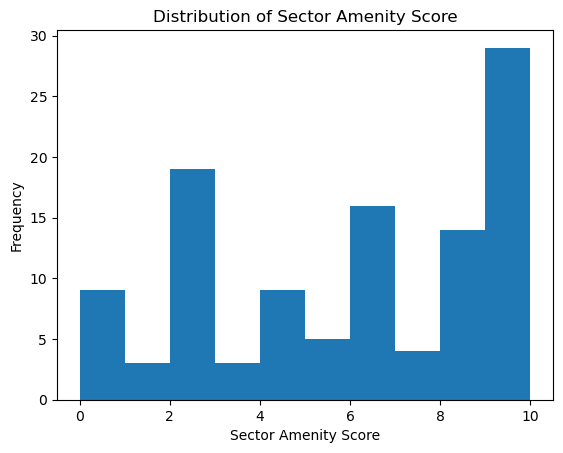

In [36]:
## Plotting Histogram - Distribution of 'Amenity Score' across Sectors:
sector_amenities['Sector_Amenity_Score'].plot(kind='hist', title = 'Distribution of Sector Amenity Score'
                                             , xlabel = 'Sector Amenity Score')

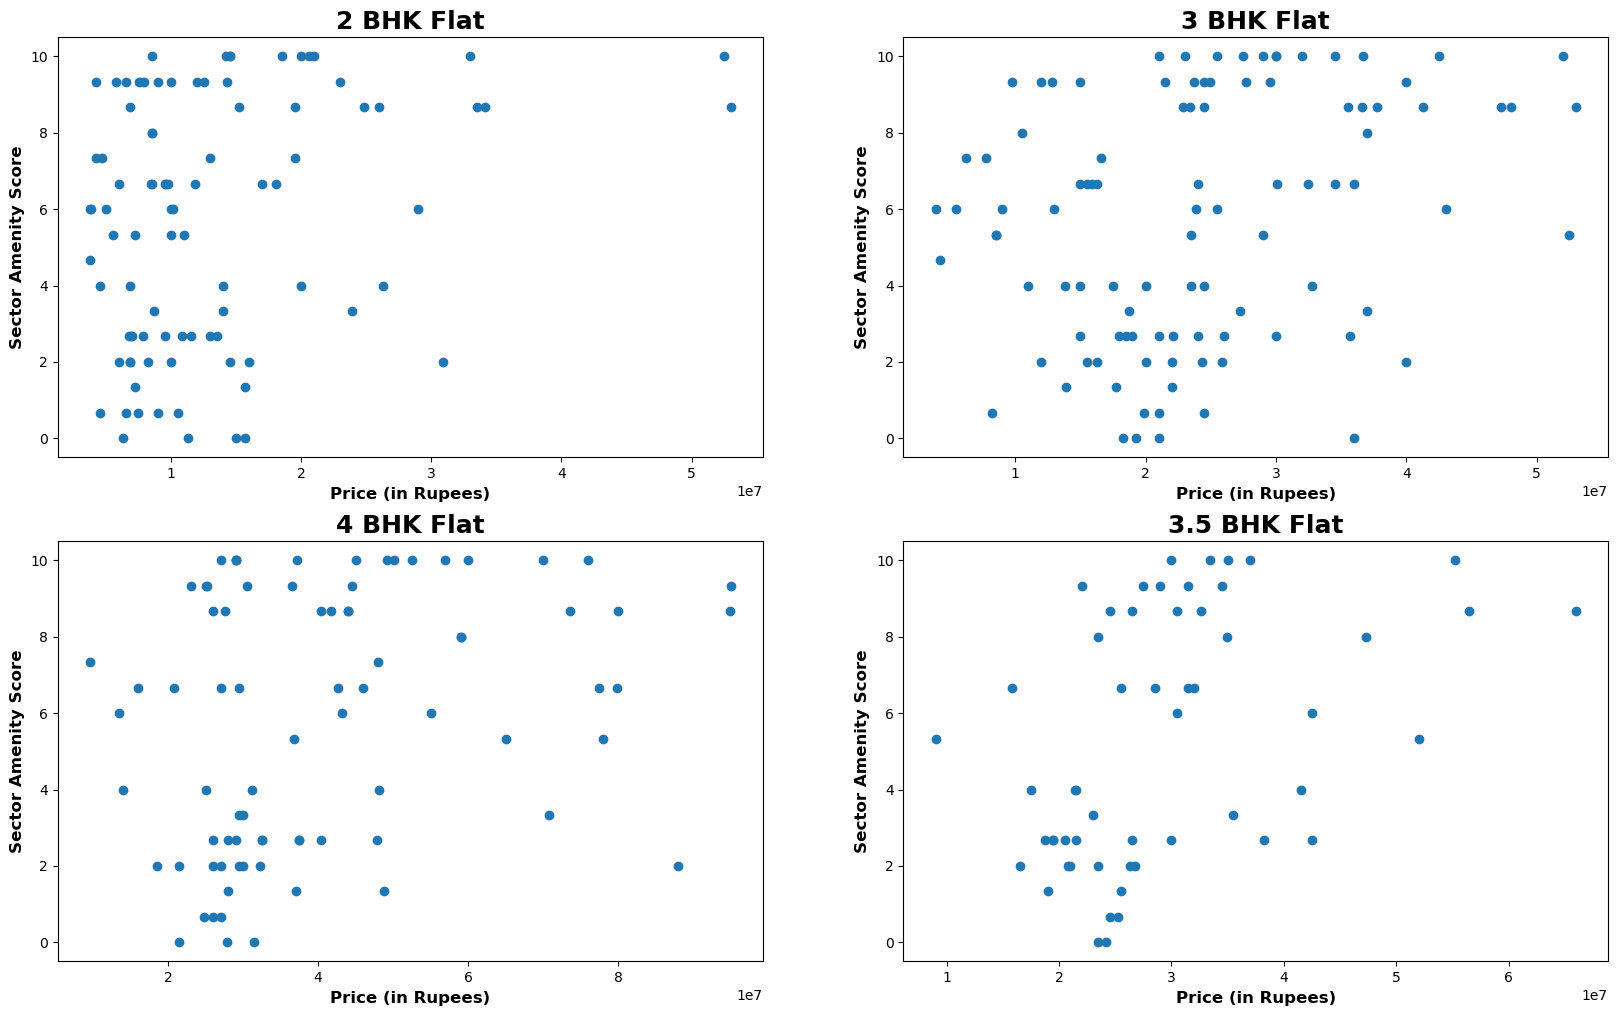

For ' 2 BHK Flat ' Type: Correlation between Amenity Score and Median Price is ->  0.2908707146014357
For ' 3 BHK Flat ' Type: Correlation between Amenity Score and Median Price is ->  0.27903835269407307
For ' 4 BHK Flat ' Type: Correlation between Amenity Score and Median Price is ->  0.3053865391759991
For ' 3.5 BHK Flat ' Type: Correlation between Amenity Score and Median Price is ->  0.4315739317987835


In [37]:
## Plotting Scatter Plot of "Median Price" vs "Amenity Score" for different Flat Types:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (20,12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

correlation_scores = []

for flat, ax in zip(['2 BHK Flat', '3 BHK Flat', '4 BHK Flat', '3.5 BHK Flat'], [ax1, ax2, ax3, ax4]):
    prices = df[df['Flat'] == flat].groupby(by='Sector')[['Price_in_rupees'
                                                         ]].median().reset_index(drop=False)
    scores = sector_amenities.reset_index(drop=False
                                         ).groupby(by='Sector'
                                                  )['Sector_Amenity_Score'].max().reset_index(drop=False)

    prices_scores = pd.merge(prices, scores , left_on = 'Sector', right_on = 'Sector', how = 'inner')
    prices_scores = prices_scores[prices_scores['Price_in_rupees'] < 100000000]
    
    ax.scatter(x = prices_scores['Price_in_rupees'] , y = prices_scores['Sector_Amenity_Score'])
    ax.set_title(flat, fontsize = 18, fontweight = 'bold')
    ax.set_xlabel('Price (in Rupees)\n', fontsize = 12, fontweight = 'bold')
    ax.set_ylabel('Sector Amenity Score', fontsize = 12, fontweight = 'bold')

    correlation_scores.append((flat, 
                               prices_scores['Price_in_rupees'
                               ].corr(prices_scores['Sector_Amenity_Score'])))

plt.show()

for flat, corr_score in correlation_scores:
    print("For '", flat, "' Type: Correlation between Amenity Score and Median Price is -> ",
          corr_score)

---
### **📌 OBSERVATION: Correlation between "Sector Amenity Score" & "Median Property Prices"**

#### **Finding:**  
+ After constructing the **Sector-wise Amenity Score** feature (based count of amenities of different types in each of the sector), I have computed the **Pearson correlation coefficient** between `Sector_Amenity_Score` and the **Median Price** of properties in that sector.
+ The result showed a **very low positive correlation**, indicating that **amenity availability alone does not strongly explain sector-level price variation** in the dataset.

#### **Possible Reasons for this Trend:**
1. **Price influenced by other factors** such as property age, builder reputation, and proximity to high-demand commercial hubs, which may overshadow amenity effects.
2. **Amenities may be uniformly distributed** across high- and low-priced sectors in Gurgaon, reducing predictive signal.
3. The **weighting scheme** for amenities might not accurately reflect buyer preferences in the location.

---

#### **`Conclusion :`**
Although there is no strong positive correlation between the Sector Amenity Score and the Median Price of Property in that sector, there are certain local patterns that could still contribute to enriching the capability of Price Prediction ML model.

---
---


### Adding "Sector Amenity Score" to main Data frame:

In [38]:
## Preparing Sector Amenity Scores for merging with main Data Frame:
scores = sector_amenities[['Sector_Amenity_Score']].reset_index(drop=False, 
                                                                level=0).reset_index(drop=True)

## Merging...
df = pd.merge(df, scores, on = 'Sector', how='left')
df['Sector_Amenity_Score'] = df['Sector_Amenity_Score'].fillna(0)
df.sample(3)

,Flat,Sector,Address,Seller_Builder,EMI,EMI_in_rupees,Built_Up_Area,Built_up_area_in_sqft,Avg_Price,Avg_price_rupee_per_sqft,Age_of_property,Age_of_property_in_years,Possession_status,Floor,Floor_number,Building_height,Facing,Furnishing,Society,Brokerage,Brokerage_in_rupees,Price,Price_in_rupees,Bedrooms,Bathrooms,Parking,Covered_parking,Open_parking,Balcony,Advertised,Amenities,Nearby_landmarks,Prop_description,Link,Sector_Amenity_Score
1262,1 RK Flat,-,"DLF Phase 5, Gurgaon",NaN,EMI starts at ₹11.92 K,11920,200 sq.ft,200,₹11.25 K/sq.ft,11250.0,99 Year Old,99,Ready to move,3 of 19,3,19,North-East facing,Semi Furnished,-,No Charge,0,22.5 L,2250000,1,1,1 Covered and 1 Open Parking,1,1,1,20 days ago,"['Gym', 'Lift', 'Garden', 'Sports', 'Kids Area...","[['School', 'Unicosmos School'], ['Hospital', ...",1 RK Flat for sale in Gurgaon. This property i...,https://housing.com/in/buy/resale/page/1314280...,0.0
6756,3 BHK Flat,Sector 50,"Unitech The Close South, Nirvana Country, Sect...",Unitech Limited,EMI starts at ₹2.11 Lacs,211000,2470 sq.ft,2470,₹17.21 K/sq.ft,17210.0,9 Year Old,9,Ready to move,12 of 18,12,18,North-West facing,Semi Furnished,Unitech The Close South,4.3 Lacs,430000,4.25 Cr,42500000,3,2,2 Covered Parking,2,0,3,More than a month ago,"['Microwave', 'Stove', 'Gas Pipeline', 'AC', '...","[['School', 'Lotus Valley International School...",Best 3 BHK Flat for modern-day lifestyle is no...,https://housing.com/in/buy/resale/page/1749252...,10.0
5657,4 BHK Flat,Sector 91,"DLF New Town Heights 3, Sector 91, Gurgaon",DLF,EMI starts at ₹1.34 Lacs,134000,2400 sq.ft,2400,₹11.25 K/sq.ft,11250.0,12 Year Old,12,Ready to move,8 of 25,8,25,-,Semi Furnished,DLF New Town Heights 3,2.7 Lacs,270000,2.7 Cr,27000000,4,4,2 Covered Parking,2,0,3,2 days ago,"['Gas Pipeline', 'Cupboard', '8Fan', '31Light'...","[['School', 'Delhi Public School, Sector 84'],...","4 BHK Flat for sale in Sector 91, Gurgaon with...",https://housing.com/in/buy/resale/page/1793286...,2.0


### **Saving the DF with New Features in a CSV File:**

In [46]:
## Saving Sector Amenity Score as a new Feature in Main cleaned dataframe:
df.to_csv('Housing_Listings_all_records_(numbers)_FINAL_Cleaned_FE.csv')

---
---